In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import calendar
import operator
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

from hyperopt import STATUS_OK, hp, fmin, tpe, Trials, space_eval

##Data exploration

In [2]:
# Import data
df_train = pd.read_csv("./data/train.csv", sep=";")
df_test = pd.read_csv("./data/test.csv", sep=";")

target = df_train["TARGET_VARIABLE"]
# Binarize target variable values
target = target.replace(to_replace=["GRANTED", "NOT GRANTED"], value=[1, 0])
df_train.drop("TARGET_VARIABLE", axis=1, inplace=True)

# Concatenate train and test for data preprocessing.
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

### Features importance

Given that the number of explanatory variables is quite high (49 features), knowing which variable is important is  helpful in order to create new variables or to try to fill missing values of those important variables.

Using a simple xgboost model, we plot the features importance.

In [3]:
# Missing values have to be imputed in order to create an xgboost model.
def impute_missing_values(X):
    # Impute missing values in numeric columns with the mean.
    for numeric_col in X.columns[X.dtypes != "object"]:
        X[numeric_col].fillna(X[numeric_col].mean(), inplace=True)
        
    # Replace NaN values in categorical variables by "Missing value".
    for categorical_col in X.columns[X.dtypes == "object"]:
        X.loc[X[categorical_col].isnull(), categorical_col] = "Missing value"
        
    # Replace values in categorical variables with integers from 0 to nb_categorical - 1.
    X[X.columns[X.dtypes == "object"]] = X[X.columns[X.dtypes == "object"]]\
    .apply(LabelEncoder().fit_transform)

# Create a copy of the training set for plotting.
df_train_copy = df_train.copy()
impute_missing_values(df_train_copy)

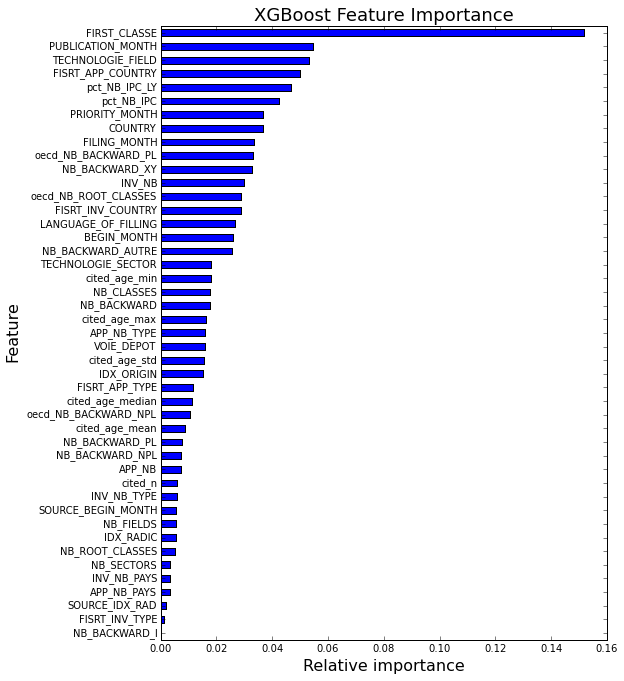

In [4]:
parameters = {"eta": 0.1, "objective": "binary:logistic", "eval_metric": "auc"}
nb_trees = 100

# Load data into an xgboost DMatrix that optimises memory efficiency and training speed.
D_train = xgb.DMatrix(df_train_copy, label=target)
xgb_model = xgb.train(parameters, D_train, nb_trees)

# Free up memory.
del df_train_copy

# get_score() gives features importance defined as: the number of time the feature
# is used to split the data across all trees.
features_importance = xgb_model.get_score()
features_importance = sorted(features_importance.items(), key=operator.itemgetter(1))

df_importance = pd.DataFrame(features_importance, columns=["Feature", "Score"])
# Divide by the sum of scores to have relative importance of each feature.
df_importance["Score"] = df_importance["Score"] / df_importance["Score"].sum()

# Plot the importance of each feature in decreasing order.
df_importance.plot(kind="barh", x="Feature", y="Score", legend=False, figsize=(8, 11))
plt.title("XGBoost Feature Importance", size=18)
plt.xlabel("Relative importance", size=16)
plt.ylabel("Feature", size=16)
plt.show()

This graph will help us create new variables or motivate us to find a clever way to fill missing values of important features.

###International Patent Classification (IPC)

__Wikipedia__: 
>The International Patent Classification (IPC) is a hierarchical patent classification system used in over 100 countries to classify the content of patents in a uniform manner.

As we're trying to classify patents, the IPC (such as _A01B1/00_) is probably a relevant variable that we can actually break down in four levels:

* The first letter is the __section symbol__: A corresponds to "Human Necessities" ;
* The following two digits give a __class symbol__: A01 represents "Agriculture; forestry; animal husbandry; trapping; fishing" ;
* The final letter makes up the __subclass__: A01B represents "Soil working in agriculture or forestry; parts, details, or accessories of agricultural machines or implements, in general" ;
* The subclass is then followed by one-to-three digit __group__ number, an oblique stroke and a number of at least two digits representing a __main group__ or __subgroup__.

In [5]:
# The variables FIRST_CLASSE and MAIN_IPC contain the relevant information about IPC
# as shown below.
df_all[["FIRST_CLASSE", "MAIN_IPC"]].head()

,FIRST_CLASSE,MAIN_IPC
0,A61K9/48,A61K
1,C08G65/26,C08G
2,G11B15/07,G11B
3,F25B41/04,F25B
4,H01F17/06,H01F


In [6]:
# Break down the IPC in four levels as described above.
def break_down_IPC(X):
    
    X["section_symbol"] = X["FIRST_CLASSE"].str.extract(r'^([A-Z]{1})', expand=True)
    X["class_symbol"] = X["FIRST_CLASSE"].str.extract(r'^([A-Z]{1}[0-9]{2})', expand=True)
    X["subclass"] = X["FIRST_CLASSE"].str.extract(r'^([A-Z]{1}[0-9]{2}[A-Z]{1})', expand=True)
    X["group"] = X["FIRST_CLASSE"].str.extract(r'^(.*?)/', expand=True)
    
    # Drop MAIN_IPC as it now redundant with subclass.
    X.drop('MAIN_IPC', axis=1, inplace=True)

### The dates

__Filing date and priority date, bios.net__:
>The __filing date__ is the date when a patent application is first filed at a patent office. The __priority date__ is the date used to establish the novelty and/or obviousness of a particular invention relative to other art.

The priority date is often earlier than the filing date but the two can happen to be equal if an application claims priority to a previous parent application. Therefore, it might be useful to create a new variable giving the time elapsed between priority date and filing date.

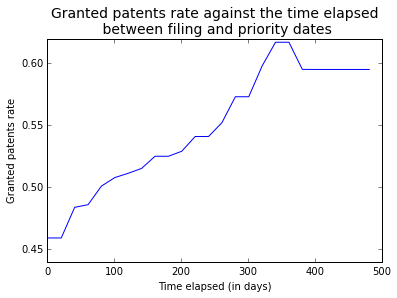

In [7]:
# Convert a date formated as MM/YYYY to a time.
def to_time(date_string):
    date_format = "%m/%Y"
    if date_string is np.nan:
        return None
    return calendar.timegm(datetime.datetime.strptime(str(date_string), date_format)\
                           .utctimetuple())

# Number of days elapsed between filing date and priority date.
df_train["time_filing_priority"] = (df_train["FILING_MONTH"].map(to_time) - \
                                    df_train["PRIORITY_MONTH"].map(to_time)) \
                                   / (3600 * 24)
    
# Plot the effect of that new variable on the granted patents rate.
nb_days_elapsed = range(1, 500, 20)
granted_rate = map(lambda x: (target[df_train["time_filing_priority"] < x] == 1).mean(),
                   nb_days_elapsed)

plt.plot(nb_days_elapsed, granted_rate)
plt.title("Granted patents rate against the time elapsed \n between filing and priority dates",
          size=14)
plt.xlabel("Time elapsed (in days)")
plt.ylabel("Granted patents rate")
plt.show()

This graph seems to show that the time elapsed between filing and priority dates is positively correlated with the granted patents rate. An application with the same filing and priority dates might be linked with a parent application thus reducing the chance of true novelty.

__Begin date and publication date__
> The __begin date__ corresponds to the minimum between the filing date and the priority date (in some rare case, the priority date can be before the filing date). The __publication date__ represents the date at which the patent application is published.

Likewise, it might be interesting the know the time elapsed between those two dates.

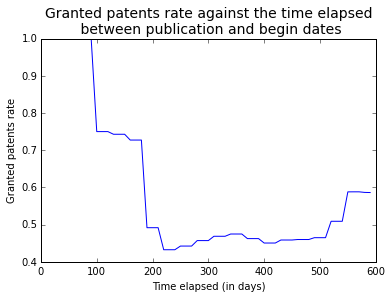

In [8]:
# Number of days elapsed between publication date and begin date.
df_train["time_publication_begin"] = (df_train["PUBLICATION_MONTH"].map(to_time) \
                                      - df_train["BEGIN_MONTH"].map(to_time)) \
                                     / (3600 * 24)
    
# Plot the effect of that new variable on the granted patents rate.
nb_days_elapsed = range(50, 600, 10)
granted_rate = map(lambda x: (target[df_train["time_publication_begin"] < x] == 1).mean(),
                   nb_days_elapsed)

plt.plot(nb_days_elapsed, granted_rate)
plt.title("Granted patents rate against the time elapsed \n between publication and begin dates",
          size=14)
plt.xlabel("Time elapsed (in days)")
plt.ylabel("Granted patents rate")
plt.show()

In accordance with our intuition, a shorter interval between the begin date and the publication date seems correlated with a higher patent grating rate.

In [9]:
# In summary:
def date_preprocessing(X):
    # Extract the elapsed time.
    X["time_filing_priority"] = (X["PUBLICATION_MONTH"].map(to_time) - X["BEGIN_MONTH"]\
                                 .map(to_time)) / (3600 * 24)
    X["time_publication_begin"] = (X["FILING_MONTH"].map(to_time) - X["PRIORITY_MONTH"]\
                                   .map(to_time)) / (3600 * 24)
    
    # Extract the month and the year.
    for col in ["PRIORITY_MONTH", "FILING_MONTH", "BEGIN_MONTH", "PUBLICATION_MONTH"]:
        X[[col, col[0:-len("_MONTH")] + "_YEAR"]] = X[col].str.extract(r'([\d]{2})/([\d]{4})',
                                                                       expand=True)

### Patent's country

The patent's country is a really valuable information as regulations are not the same in every country. Yet, the _COUNTRY_ variable is missing quite a few values as shown below:

In [10]:
sum(df_all["COUNTRY"].isnull())

32891

We thus replace the missing values of _COUNTRY_ by the most associated _COUNTRY_ according to its _FISRT_APP_COUNTRY_.

In [11]:
def replace_country(X):
    # Group by FISRT_APP_COUNTRY and count COUNTRY values.
    associated_country = X.groupby("FISRT_APP_COUNTRY")["COUNTRY"].value_counts()\
                         .reset_index(name="count")
    # Compute the index of the most recurrent COUNTRY for each FISRT_APP_COUNTRY.
    max_index = associated_country.groupby("FISRT_APP_COUNTRY").transform(max)["count"] \
                == associated_country["count"]
    # Only keep the most recurrent COUNTRY and drop duplicates in case several countries 
    # occur the same number of time.
    associated_country = associated_country[max_index].drop_duplicates("FISRT_APP_COUNTRY")

    # Create a dictionary associating FISRT_APP_COUNTRY to COUNTRY.
    country_dict = associated_country.set_index("FISRT_APP_COUNTRY")["COUNTRY"].to_dict()

    # Replace the missing values of COUNTRY.
    missing_country = X["COUNTRY"].isnull()
    X.loc[missing_country, "COUNTRY"] = X.loc[missing_country, "FISRT_APP_COUNTRY"]\
                                        .replace(country_dict) 

##Data preprocessing

After this exploration, let us now actually preprocess our data.

In [12]:
def preprocessing(X):
    
    # Create the four levels for IPC.
    break_down_IPC(X)
    
    # Preprocess the dates.
    date_preprocessing(X)
    
    # Replace missing values of COUNTRY.
    replace_country(X)
    
    # Impute the missing values.
    impute_missing_values(X)

In [13]:
preprocessing(df_all)

# Recreate train and test data frame.
df_train, df_test = df_all[:len(df_train)], df_all[len(df_train):]

## Hyperparameters tuning

Tuning the hyperparameters of our model is essential to ensure that the extreme gradient booster (xgboost) best fits our data:

* __eta__: learning rate. A low learning rate ($<0.1$) yields models which avoid overfitting but require more trees.
* __max_depth__: maximum tree depth. High values might lead to a model fitting too closely the training set.
* __min_child_weight__: Minimum sum of weight needed in a child. High values will lead to a more conservative model.
* __gamma__: minimum loss reduction required to create an additionnal split on a leaf. The larger the gamma, the more conservative the algorithm will be.
* __subsample__: subsample ratio of the training set. Setting this parameter lower than 1 helps avoiding overfitting.
* __lambda__: $L_2$ regularisation in order to reduce overfitting.

We will use a randomised grid search in order to find the best hyperparameters, given that each cross-validation is computationally expensive.

In [15]:
# Scoring function in the hyperopt hyperparameters tuning.
def scoring_function(parameters):

    print("Training the model with parameters: ")
    print(parameters)
    
    random_state = 0
    nb_trees = 500
    early_stopping_rounds = 25
    average_score = 0.0
    nb_splits = 5

    stratified_fold = StratifiedKFold(n_splits=nb_splits, random_state=random_state)
    for train_index, validation_index in stratified_fold.split(df_train, target):
        X_train, X_validation = df_train.ix[train_index], df_train.ix[validation_index]
        y_train, y_validation = target[train_index], target[validation_index]
        D_train = xgb.DMatrix(X_train, label=y_train)
        D_validation = xgb.DMatrix(X_validation, label=y_validation)

        watchlist = [(D_train, 'Training'), (D_validation, 'Validation')]
        xgb_model = xgb.train(parameters, D_train, nb_trees, watchlist, 
                              early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=10, maximize=True)

        y_predict = xgb_model.predict(D_validation, ntree_limit=xgb_model.best_iteration)
        average_score += roc_auc_score(y_validation, y_predict)

    average_score /= nb_splits

    print("Cross-validation score: {0}".format(average_score))
    
    return {"loss": 1 - average_score, "status": STATUS_OK}

In [16]:
%%capture
t0 = time.time()

# Grid to pick parameters from.
parameters_grid = {"eta": hp.quniform("eta", 0.01, 0.1, 0.01),
         "max_depth": hp.choice("max_depth", np.arange(3, 12, dtype=int)),
         "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
         "gamma": hp.quniform("gamma", 0, 1, 0.2),
         "subsample": hp.quniform("subsample", 0.5, 1, 0.2),
         "lambda": hp.quniform("lambda", 0, 1, 0.2),
         "objective": "binary:logistic",
         "eval_metric": "auc",
         "silent": 0
        }
# Record the information about the cross-validation.
trials = Trials()

best = fmin(scoring_function, parameters_grid, algo=tpe.suggest, max_evals=10, 
            trials=trials) 

computingTime = time.time() - t0

In [17]:
# Save the best parameters as a csv.
best_parameters = pd.DataFrame({key: [value] for (key, value) in 
                                zip(space_eval(parameters_grid, best).keys(),
                                    space_eval(parameters_grid, best).values())})
# Add the corresponding score.
best_parameters["score"] = max(map(lambda(x): 1-x, trials.losses()))
best_parameters.to_csv("./hyperparameters_tuning/best_parameters.csv", index=False)

#Feature selection

Now that we tuned the hyperparameters, the next step is feature selection. Some features might be redundant or uninformative and unnecessarily add complexity to the model. A simpler model will generalise better that is why we will remove the features with very low variance.

In [18]:
# Load best parameters.
best_parameters = pd.read_csv("./hyperparameters_tuning/best_parameters.csv")
best_parameters = dict(zip(list(best_parameters.columns[:-1]), 
                           list(best_parameters.loc[0,:].values)[:-1]))
# Remove "eval_metric" which is not accepted in the sklearn wrapper.
best_parameters.pop("eval_metric", None)
# Rename variable "eta" and "lambda" according to the sklearn wrapper.
best_parameters["learning_rate"] = best_parameters.pop("eta")
best_parameters["reg_lambda"] = best_parameters.pop("lambda")

sfm = SelectFromModel(xgb.XGBClassifier(n_estimators=500, **best_parameters),
                      threshold=0.001)
sfm.fit(df_train, target)

nb_features = sfm.transform(df_train).shape[1]
print("{0} features were selected.".format(nb_features))

50 features were selected.


## Final tuning of the hyperparameters

Let us now tune more finely the hyperparameters of the model with the selected features.

In [19]:
df_train = df_train.loc[:, sfm.get_support()]
df_test = df_test.loc[:, sfm.get_support()]

In [20]:
%%capture
t0 = time.time()

# Finer grid to pick hyperparameters from.
parameters_grid_final = {"eta": hp.quniform("eta", 0.01, 0.05, 0.01),
         "max_depth": hp.choice("max_depth", np.arange(8, 12, dtype=int)),
         "min_child_weight": hp.quniform("min_child_weight", 4, 8, 1),
         "gamma": hp.quniform("gamma", 0.6, 1.2, 0.2),
         "subsample": hp.quniform("subsample", 0.6, 1.0, 0.1),
         "lambda": hp.quniform("lambda", 0, 0.4, 0.1),
         "objective": "binary:logistic",
         "eval_metric": "auc",
         "silent": 0
        }
trials_final = Trials()

best_final = fmin(scoring_function, parameters_grid_final, algo=tpe.suggest, max_evals=10, 
            trials=trials_final)

computingTime = time.time() - t0

In [21]:
# Save the final best parameters as a csv.
best_parameters_final = pd.DataFrame({key: [value] for (key, value) in 
                                zip(space_eval(parameters_grid_final, best_final).keys(),
                                    space_eval(parameters_grid_final, best_final).values())})
# Add the corresponding score.
best_parameters_final["score"] = max(map(lambda(x): 1-x, trials_final.losses()))
best_parameters_final.to_csv("./hyperparameters_tuning/best_parameters_final.csv", index=False)

In [22]:
best_parameters_final

,eta,eval_metric,gamma,lambda,max_depth,min_child_weight,objective,silent,subsample,score
0,0.02,auc,0.8,0.1,11,6.0,binary:logistic,0,0.8,0.714538


##Final Model

In [35]:
# Load final best parameters.
best_parameters_final = pd.read_csv("./hyperparameters_tuning/best_parameters_final.csv")
best_parameters_final = dict(zip(list(best_parameters_final.columns[:-1]), 
                                 list(best_parameters_final.loc[0,:].values)[:-1]))

In [36]:
nb_trees = 500

# Predict test data.
D_train = xgb.DMatrix(df_train, label=target)
D_test = xgb.DMatrix(df_test)
    
xgb_model_final = xgb.train(best_parameters_final, D_train, nb_trees)

prediction_final = xgb_model_final.predict(D_test)
np.savetxt("./prediction/final_prediction.txt", prediction_final, fmt='%s')